# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [2]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
#!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
#!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

!wget https://www.dropbox.com/s/mty4u14v7l1vyi6/positive.csv
!wget https://www.dropbox.com/s/15v2y2g9cuipjv3/negative.csv

--2022-06-26 15:40:27--  https://www.dropbox.com/s/mty4u14v7l1vyi6/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mty4u14v7l1vyi6/positive.csv [following]
--2022-06-26 15:40:27--  https://www.dropbox.com/s/raw/mty4u14v7l1vyi6/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc17ef04417608fd648035552dda.dl.dropboxusercontent.com/cd/0/inline/Bn8yHCzxnIG-sGppfNhIkGe4RJFy0RbRPnSmqMrNT8T_BldnWNaqVDR8PD5uc84jcEcXZ6tUsGKkit4RUqaArG_rGcFd3xMbzld4AVMbROs_YpE0z4XSbQuMDCzECp7O0FEyAGiDakd7aYUcZS11mRmsUEmV5PKFoUI2lxAvtbN6Fw/file# [following]
--2022-06-26 15:40:27--  https://uc17ef04417608fd648035552dda.dl.dropboxusercontent.com/cd/0/inline/Bn8yHCzxnIG-sGppfNhIkGe4RJFy0RbRPnSmqMrNT8T_BldnWNaqVDR8PD5uc84jcEcX

In [3]:
import pandas as pd
import numpy as np

import nltk

from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [4]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [4]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [6]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [7]:
from nltk import ngrams

In [8]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [9]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [10]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [11]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [12]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [13]:
list(vec.vocabulary_.items())[:10]

[('rt', 74645),
 ('yana_guyer', 94051),
 ('жизнь', 131814),
 ('боль', 107407),
 ('нечего', 168148),
 ('делать', 124533),
 ('кода', 146290),
 ('вк', 112937),
 ('не', 165645),
 ('работает', 199704)]

In [14]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [15]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.78      0.75      0.77     28743
    positive       0.76      0.78      0.77     27966

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



Попробуем сделать то же самое для триграмм:

In [16]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.85      0.57      0.68     41503
    positive       0.38      0.73      0.50     15206

    accuracy                           0.61     56709
   macro avg       0.62      0.65      0.59     56709
weighted avg       0.73      0.61      0.63     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.74      0.77      0.76     27032
    positive       0.78      0.76      0.77     29677

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [19]:
from nltk import collocations 
nltk.download('genesis')
nltk.download('punkt')

print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('+1239', '728'), ('+375447167151', 'звоги'), ('+Никита', '=полностью'), ('+СОННО', '+НЕ'), ('+живіт', 'болить.ну'), (',4', 'запирайте'), (',как', 'додики'), ('-/////', 'прбрм-прбрм'), ('-10,11', 'болсо'), ('-163', '-КРАСНЫЙ'), ('-165', '-СИНИЙ'), ('-53', 'dBm'), ('-800', 'нахууй'), ('-АХАХАХАХ', 'ЮБКУ'), ('-АХАХАХАХХАХАХАХАХАХХА', '-АХАХАХХАХАХАХАХАХ'), ('-Айгуль', 'Маратовна'), ('-Алина', '-Синие'), ('-Без', 'презерватива'), ('-Белоснежная', 'мантия'), ('-ВАХАХАХА', 'СТИПЕНДИЯ'), ('-ВСЕМ', 'СПОКОЙНЫХ'), ('-Вам', 'завернуть'), ('-Весело', 'кншн:3'), ('-Восьмигрудый', 'трипи'), ('-Время', 'эмокора'), ('-Выздоравливай', 'педрилк'), ('-ГНИДОТА', '-Над'), ('-ДЕТЕЙ', 'НАКРЫЛО'), ('-ДОВАЙТИ', 'АЛДСКУЛ'), ('-Дирол', 'Сенсес'), ('-Домашка', '-кл.час'), ('-ЖРАТЬ', 'БАРАНКИ'), ('-ЗАШЛА', 'ОДЕЛА'), ('-Защитано', '-ес'), ('-Зелено-карие', '-Киллджой'), ('-КРАСНЫЙ', '-ЧЕРНЫЕ'), ('-Керем', 'севгили'), ('-Киллджой', '-Котик'), ('-Корнейчук', 

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [20]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('*', '*'), ('у', 'нас'), ('(', ','), (':', ')'), (':', '-'), ('не', 'могу'), (',', '('), (',', ')'), ('?', '?'), (')', ','), (',', ':'), ('@', '('), (',', ','), (':', ','), ('(', ':'), ('@', ')'), ('&', 'lt'), ('@', ','), ('со', 'мной'), ('@', ':'), ('(', '@'), ('gt', ';'), (':', ':'), ('новый', 'год'), (')', ':'), (';', ')'), (',', '@'), (':', '*'), ('не', 'знаю'), ('а', 'я'), ('@', '@'), (',', 'когда'), ('У', 'меня'), ('lt', ';'), ('потому', 'что'), ('сих', 'пор'), ('&', 'gt'), ('у', 'тебя'), (';', '('), ('с', 'тобой'), ('все', 'равно'), (',', 'как'), ('в', 'школу'), ('&', 'amp'), ('(', 'http'), ('Доброе', 'утро'), ('Как', 'же'), ('ничего', 'не'), (')', '@'), (',', 'я'), ('-', ')'), ('я', 'не'), (':', 'DD'), ('не', '('), ('самом', 'деле'), ('как', 'же'), ('не', ')'), ('amp', ';'), ('до', 'сих'), ('(', '!'), (',', '!'), (',', 'ч

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [21]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [24]:
from nltk.tokenize import word_tokenize

vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29295
    positive       0.76      0.80      0.78     27414

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [25]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2022-06-26 11:37:38--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.241, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cachev2-mskm909.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-06-26 11:37:40--  https://cachev2-mskm909.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm909.cdn.yandex.net (cachev2-mskm909.cdn.yandex.net)... 5.45.220.120, 2a02:6b8:0:2002::920
Connecting to cachev2-mskm909.cdn.yandex.net (cachev2-mskm909.cdn.yandex.net)|5.45.220.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linu

In [26]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [27]:
example = 'Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.'

In [28]:
print(mystem_analyzer.lemmatize(example))

['метод', ' ', 'Mystem', ' ', 'принимать', ' ', 'строка', ', ', 'токенизатор', ' ', 'вшивать', ' ', 'внутри', '. ', 'можно', ', ', 'конечно', ', ', 'и', ' ', 'пословный', ' ', 'анализировать', ', ', 'но', ' ', 'тогда', ' ', 'он', ' ', 'не', ' ', 'смочь', ' ', 'учитывать', ' ', 'контекст', '.', '\n']


А можно получить грамматическую информацию:

In [29]:
mystem_analyzer.analyze(example)

[{'analysis': [{'gr': 'S,муж,неод=(вин,мн|им,мн)',
    'lex': 'метод',
    'wt': 0.9096819162}],
  'text': 'Методы'},
 {'text': ' '},
 {'analysis': [], 'text': 'Mystem'},
 {'text': ' '},
 {'analysis': [{'gr': 'V=непрош,мн,изъяв,3-л,несов,пе',
    'lex': 'принимать',
    'wt': 1}],
  'text': 'принимают'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,жен,неод=вин,ед', 'lex': 'строка', 'wt': 1}],
  'text': 'строку'},
 {'text': ', '},
 {'analysis': [{'gr': 'S,муж,неод=(вин,ед|им,ед)',
    'lex': 'токенизатор',
    'qual': 'bastard',
    'wt': 0.4851464629}],
  'text': 'токенизатор'},
 {'text': ' '},
 {'analysis': [{'gr': 'V=прош,ед,прич,кр,муж,сов,страд',
    'lex': 'вшивать',
    'wt': 1}],
  'text': 'вшит'},
 {'text': ' '},
 {'analysis': [{'gr': 'ADV=', 'lex': 'внутри', 'wt': 0.3852840662}],
  'text': 'внутри'},
 {'text': '. '},
 {'analysis': [{'gr': 'ADV,прдк=', 'lex': 'можно', 'wt': 1}], 'text': 'Можно'},
 {'text': ', '},
 {'analysis': [{'gr': 'ADV,вводн=', 'lex': 'конечно', 'wt': 0.998961

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [30]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [31]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.78      0.74      0.76     29103
    positive       0.74      0.77      0.76     27606

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [32]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 8.2 MB 23.0 MB/s 


In [33]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [34]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [35]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [36]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [38]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [39]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.4 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 41 kB 135 kB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=eee8b0952c7e4616e7a052015c09e5f8d9d8f8737d32e17ef8ea2a84a47461bd
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


С помощью библиотеки natasha можно также лемматизировать тексты.

In [40]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [41]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'(': '(',
 ')': ')',
 ',': ',',
 '.': '.',
 '1': '1',
 '11': '11',
 '110-летия': '110-летие',
 '1909': '1909',
 '1909-1959': '1909-1959',
 '2010': '2010',
 '2019': '2019',
 'Twitter': 'twitter',
 '«': '«',
 '»': '»',
 'Бандера': 'бандера',
 'Бандере': 'бандера',
 'Бандеры': 'бандера',
 'В': 'в',
 'Верховной': 'верховный',
 'Виктора': 'виктор',
 'Героем': 'герой',
 'Героя': 'герой',
 'Житомирский': 'житомирский',
 'Израиля': 'израиль',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'Львовский': 'львовский',
 'Львовской': 'львовский',
 'ОУН': 'оун',
 'Организации': 'организация',
 'Парламентарии': 'парламентарий',
 'Петру': 'петр',
 'Порошенко': 'порошенко',
 'Посол': 'посол',
 'Рады': 'рада',
 'России': 'россия',
 'Свое': 'свой',
 'Степан': 'степан',
 'Степана': 'степан',
 'Украина': 'украина',
 'Украине': 'украина',
 'Украины': 'украина',
 'Ющенко': 'ющенко',
 'Я': 'я',
 'а': 'а',
 'аналогичное': 'аналогичный',
 'антисемитизмом': 'антисемитизм',
 'антисемитских': 'антисемитский',
 'бороться': '

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [42]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [43]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292578, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970059, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [44]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [45]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [46]:
from collections import Counter

In [47]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [48]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

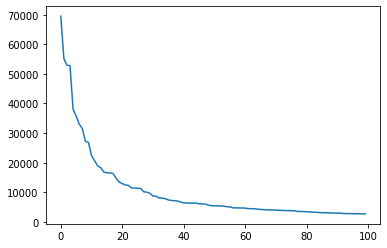

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [1]:
!wget https://www.dropbox.com/s/mty4u14v7l1vyi6/positive.csv
!wget https://www.dropbox.com/s/15v2y2g9cuipjv3/negative.csv

--2022-06-29 11:33:52--  https://www.dropbox.com/s/mty4u14v7l1vyi6/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mty4u14v7l1vyi6/positive.csv [following]
--2022-06-29 11:33:52--  https://www.dropbox.com/s/raw/mty4u14v7l1vyi6/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca92f457bee8a25b3f87070fb59.dl.dropboxusercontent.com/cd/0/inline/BoFRiLrCka1-aKlq7PTRnG-7-kHtgmCTd7c5BgU1YbLUL1mI3Ya-0XzABrIxTZNBeof28sfmFLLmFsE5wRZkMpESovOG22lWJdDX7QiDcv6Ufz_1lwnyHECWXxksvEOs8DLwcQtBuKnLhW72ZBUGCzejo5fSdJT4tcrLhXIUdsKs_A/file# [following]
--2022-06-29 11:33:53--  https://uca92f457bee8a25b3f87070fb59.dl.dropboxusercontent.com/cd/0/inline/BoFRiLrCka1-aKlq7PTRnG-7-kHtgmCTd7c5BgU1YbLUL1mI3Ya-0XzABrIxTZNBe

In [2]:
import pandas as pd
import numpy as np

import nltk

from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [4]:
from collections import Counter
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

from string import punctuation
punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [6]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

In [7]:
h_tokens = list(freq_dict_sorted)[:4]
m_tokens = list(freq_dict_sorted)[4:12]
l_tokens = list(freq_dict_sorted)[12:]

In [8]:
h_tokens

[('не', 69472), ('и', 55166), ('в', 52902), ('я', 52818)]

In [9]:
m_tokens

[('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860),
 ('...', 22363),
 ('меня', 20656)]

In [10]:
import re

def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = natasha_lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


    

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [30]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [32]:
#Обучение на токенах с высокой частотой
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc, stop_words=list(freq_dict_sorted)[4:])
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=400)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.75      0.77     29556
    positive       0.75      0.79      0.77     27153

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [33]:
import pickle

In [34]:
pickle.dump(clf, open('h_clf.sav', 'wb'))

In [35]:
#Обучение на токенах со средней частотой

In [36]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc, stop_words=h_tokens+l_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=400)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.75      0.77     29556
    positive       0.75      0.79      0.77     27153

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [37]:
pickle.dump(clf, open('m_clf.sav', 'wb'))

In [38]:
#Обучение на токенах с низкой частотой

In [39]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc, stop_words=h_tokens+m_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=400)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.75      0.77     29556
    positive       0.75      0.79      0.77     27153

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [40]:
pickle.dump(clf, open('l_clf.sav', 'wb'))

разницы не обнаружено, пробовал разные срезы

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [42]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27944
    positive       1.00      1.00      1.00     28765

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [87]:
corpus_with_punkt = [token for tweet in df.text for token in word_tokenize(tweet)]
print(len(corpus_with_punkt))
corpus[:10]

4027060


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [88]:
freq_dict_with_punkt = Counter(corpus_with_punkt)
freq_dict_with_punkt_sorted= sorted(freq_dict_with_punkt.items(), key=lambda x: -x[1])
list(freq_dict_with_punkt_sorted)[:10]

[('(', 212404),
 (')', 194005),
 (',', 188295),
 (':', 177675),
 ('@', 149978),
 ('не', 69472),
 ('!', 66923),
 ('.', 57595),
 ('и', 55166),
 ('в', 52902)]

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [90]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32740
    positive       0.83      1.00      0.91     23969

    accuracy                           0.91     56709
   macro avg       0.91      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [91]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.99      1.00      0.99     27732
    positive       1.00      0.99      1.00     28977

    accuracy                           1.00     56709
   macro avg       0.99      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## Домашнее задание

все материалы для выполения дз в `sem2.ipynb`


### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [12]:
# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_train)
test_y = encoder.fit_transform(y_test)

train_data = tf.data.Dataset.from_tensor_slices((x_train, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, test_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
def custom_standardization(input_data):
    
    return input_data

vocab_size = 10000
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

embedding_dim=200

In [51]:
row = list(valid_data.take(1))

In [52]:
row[0][0][0].numpy()

b'@_stone_rose_ \xd0\xa2\xd1\x8b \xd0\xb6\xd0\xb5 \xd0\xbd\xd0\xb5 \xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x88\xd1\x8c \xd1\x83\xd1\x81\xd0\xbb\xd0\xb5\xd0\xb4\xd0\xb8\xd1\x82\xd1\x8c \xd0\xb7\xd0\xb0 \xd0\xb2\xd1\x81\xd0\xb5\xd0\xbc\xd0\xb8 \xd0\xbf\xd0\xbe\xd0\xb1\xd0\xb5\xd0\xb4\xd0\xb0\xd0\xbc\xd0\xb8, \xd0\xbd\xd0\xb0\xd0\xb4\xd0\xbe \xd0\xb8\xd0\xbc \xd0\xb8 \xd1\x81\xd0\xb0\xd0\xbc\xd0\xb8\xd0\xbc \xd0\xba\xd0\xbe\xd0\xb3\xd0\xb4\xd0\xb0-\xd1\x82\xd0\xbe \xd0\xb8\xd0\xb3\xd1\x80\xd0\xb0\xd1\x82\xd1\x8c, \xd0\xb0 \xd1\x82\xd0\xbe \xd1\x81 \xd1\x82\xd0\xbe\xd0\xb1\xd0\xbe\xd0\xb9 \xd1\x80\xd0\xb0\xd1\x81\xd1\x81\xd0\xbb\xd0\xb0\xd0\xb1\xd0\xbb\xd1\x8f\xd1\x8e\xd1\x82\xd1\x81\xd1\x8f,\xd0\xb2\xd1\x81\xd0\xb5 \xd0\xb7\xd0\xb0 \xd0\xbd\xd0\xb8\xd1\x85 \xd0\xb4\xd0\xb5\xd0\xbb\xd0\xb0\xd0\xb5\xd1\x88\xd1\x8c :-)'

In [68]:
embedding_dim=200

10*100*200

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(200, (3)),
    Conv1D(200, (2)),
    GRU(300),
    #GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [69]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [70]:
model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
10633/10633 [==============================] - 154s 14ms/step - loss: 0.5347 - accuracy: 0.6605 - val_loss: 0.3787 - val_accuracy: 0.7937
Epoch 2/5
10633/10633 [==============================] - 123s 12ms/step - loss: 0.3593 - accuracy: 0.8081 - val_loss: 0.3585 - val_accuracy: 0.8070
Epoch 3/5
10633/10633 [==============================] - 137s 13ms/step - loss: 0.3485 - accuracy: 0.8152 - val_loss: 0.3726 - val_accuracy: 0.7949
Epoch 4/5
10633/10633 [==============================] - 127s 12ms/step - loss: 0.3565 - accuracy: 0.8100 - val_loss: 0.3788 - val_accuracy: 0.7967
Epoch 5/5
10633/10633 [==============================] - 124s 12ms/step - loss: 0.3549 - accuracy: 0.8112 - val_loss: 0.3782 - val_accuracy: 0.7978


In [79]:
pred = model.predict(x_test)
print(classification_report([1 if x > 0.5 else 0 for x in pred ], test_y))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     28138
           1       0.80      0.80      0.80     28571

    accuracy                           0.80     56709
   macro avg       0.80      0.80      0.80     56709
weighted avg       0.80      0.80      0.80     56709



In [81]:
from keras.models import load_model

model.save('my_model.tf')

INFO:tensorflow:Assets written to: my_model.tf/assets


INFO:tensorflow:Assets written to: my_model.tf/assets


In [17]:
x_train

93739     у фангерлы очень проблемная жизнь, потому что ...
4177      @Cryoclasm82 испытываю вегетативную неприязнь ...
54531     почему уже кто-то закончил учиться,  а мы нет? :(
11852     RT @Jmurkaa: Короч ребят фото гавно,и у тетки ...
110377      @mashatommo мне они летом и осенью как то :-(((
                                ...                        
84486     @ShokinaD да я уже так хорошо в подьезде устро...
37955     Мундаг юмаа. Амжилт "@Temkas: Марафон гvйлтээ ...
18448     пхаа\nвот и разошлись\nвсе началось, что Катя ...
53200     RT @wylsacom: Зазнался. :D\nRT @DPOH19: Хоть т...
105194    Утро начинается не с кофе !( http://t.co/awo7G...
Name: text, Length: 170125, dtype: object

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer

vct = HashingVectorizer(analyzer='word', token_pattern=r'\w{1,}', n_features=56000)
vct.fit(x_train)

xtrain_hash =  vct.transform(x_train)
xvalid_hash =  vct.transform(x_test)

classifier = LogisticRegression(random_state=42, max_iter=400)
classifier.fit(xtrain_hash, train_y)
predictions = classifier.predict(xvalid_hash)
print(classification_report(predictions, test_y))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     28389
           1       0.76      0.76      0.76     28320

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



In [28]:
print(classification_report(predictions, test_y)) #n_features=70000

              precision    recall  f1-score   support

           0       0.77      0.76      0.76     28448
           1       0.76      0.77      0.76     28261

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709

